# 4 Implementing a GPT model from scratch to genearte text

## 4.1 Coding an LLM architecture

In [3]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,      # Vocabulary size
    "context_length": 1024,   # Context length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of layers
    "drop_rate": 0.0,         # Dropout rate
    "qkv_bias": False         # Query-Key-Value bias
}

## 4.2 Normalizing activations with layer normalization

In [4]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [5]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
out.mean(dim=1, keepdim=True)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

In [8]:
out.var(dim=-1, keepdim=True)

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## 4.3 Implementing a feed forward network with GELU activations

In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

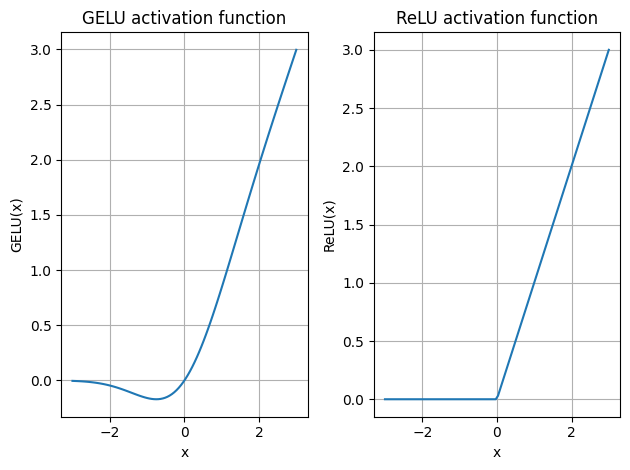

In [11]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Create 100 sample data points in the range -3 to 3
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
ffn = FeedForward(GPT_CONFIG_124M)

In [15]:
x = torch.rand(2, 3, 768)
ffn(x).shape

torch.Size([2, 3, 768])

In [16]:
ffn.layers

Sequential(
  (0): Linear(in_features=768, out_features=3072, bias=True)
  (1): GELU()
  (2): Linear(in_features=3072, out_features=768, bias=True)
)

In [17]:
ffn.layers[0].weight

Parameter containing:
tensor([[-0.0223,  0.0308,  0.0022,  ..., -0.0174, -0.0227, -0.0178],
        [-0.0027, -0.0043, -0.0274,  ...,  0.0079,  0.0112,  0.0010],
        [-0.0029,  0.0175,  0.0244,  ..., -0.0164, -0.0300,  0.0045],
        ...,
        [ 0.0255,  0.0023,  0.0277,  ..., -0.0037, -0.0134, -0.0284],
        [ 0.0266,  0.0236, -0.0193,  ...,  0.0120,  0.0061, -0.0261],
        [ 0.0222,  0.0106, -0.0190,  ..., -0.0253,  0.0320, -0.0109]],
       requires_grad=True)

## 4.4 Adding shortcut connections

## 4.5 Connecting attention and linear layers in a transformer block

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by_num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, heads_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # (b, num_heads, num_tokens, heads_dim) @ (b, num_heads, heads_dim, num_tokens)
        # -> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # (b, num_heads, num_tokens, num_tokens)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) @ (b, num_heads, num_tokens, heads_dim)
        # -> (b, num_heads, num_tokens, heads_dim)
        # -> (b, num_tokens, num_heads, heads_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        # (b, num_tokens, d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # (b, num_tokens, emb_size)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [21]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

In [22]:
x.shape

torch.Size([2, 4, 768])

In [23]:
output.shape

torch.Size([2, 4, 768])

## 4.6 Coding the GPT model

In [25]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [29]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [30]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

In [35]:
model.tok_emb.weight.shape

torch.Size([50257, 768])

In [36]:
model.out_head.weight.shape

torch.Size([50257, 768])

In [31]:
batch.shape

torch.Size([2, 4])

In [32]:
out.shape

torch.Size([2, 4, 50257])

In [33]:
batch.numel()

8

In [34]:
total_params = sum(p.numel() for p in model.parameters())
total_params

163009536

In [37]:
total_params - 50257 * 768

124412160

## 4.7 Generating text

In [42]:
torch.argmax(torch.tensor([14, 1, -2, 1]))

tensor(0)

In [63]:
def generate_text_simple(
    model,
    idx, # (b, seq_len)
    max_new_tokens,
    context_size
):    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            # (b, seq_len, vocab_size)
            logits = model(idx_cond)

        # (b, seq_len, vocab_size) -> (b, vocab_size)
        logits = logits[:, -1, :]
        # (b, vocab_size)
        probas = torch.softmax(logits, dim=-1)

        # (b, 1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # (b, seq_len + 1)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [64]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded: [15496, 11, 314, 716]


In [65]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded_tensor.shape: torch.Size([1, 4])


In [61]:
encoded_tensor

tensor([[15496,    11,   314,   716]])

In [66]:
out = generate_text_simple(model, encoded_tensor, 4, GPT_CONFIG_124M["context_length"])
out

tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961]])

In [67]:
(out.squeeze(0)).tolist()

[15496, 11, 314, 716, 27018, 24086, 47843, 30961]

In [68]:
tokenizer.decode((out.squeeze(0)).tolist())

'Hello, I am Featureiman Byeswick'